Antenna noise temperature
====
Last update: 14 Sept 2018  

This notebook walks through calculations for antenna noise temperature for the CBITS phased array.  The antenna boresight is defined as an angle normal to the longitudinal axis of the aircraft in straight and level flight.   

Radio noise is defined in Recommendation ITU-R V.573 as follows: A time-varying electromagnetic phenomenon having components in the radio-frequency range, apparently not conveying information and which may be superimposed on, or combined with, a wanted signal.  

In telecommunication, antenna noise temperature is the temperature of a hypothetical resistor at the input of an ideal noise-free receiver that would generate the same output noise power per unit bandwidth as that at the antenna output at a specified frequency. In other words, antenna noise temperature is a parameter that describes how much noise an antenna produces in a given environment. This temperature is not the physical temperature of the antenna. Moreover, an antenna does not have an intrinsic "antenna temperature" associated with it; rather the temperature depends on its gain pattern and the thermal environment that it is placed in.  

Antenna noise temperature has contributions from several sources:  
- Galactic radiation  
- Earth heating  
- The sun  
- Electrical devices  
- The antenna itself  

Galactic noise is high below 1000 MHz. At around 150 MHz, it is approximately 1000K. At 2500 MHz, it has leveled off to around 10K.  

Earth has an accepted standard temperature of 290K.  

The following notebooks are used:  
- Array factor.ipynb
- element pattern.ipynb
- Antenna noise temperature.ipynb

## ToDo
- fix calculations
    - check array factor calculations
    - check element pattern calculations
    - check math for T antenna
    - add other noise sources
    - include T vs altitude, see JPL paper
- write white paper
    - fix references
    - clean up ipynb files
    - add discussion on earth geometry


**notes from WG#2**

The actual antenna noise temperature is dependent upon the following variables:  
- Frequency of operation  
- Ohmic loss in the antenna element and radome  
- Antenna radiation pattern  
- Background temperature / environment relative to the main beam pointing vector  

Sky brightness temperature (TSKY) as a function of frequency and elevation angle  

Modeled Antenna Noise Temperature  
Model Assumptions  
Nominal flight conditions  
- Altitude: 30 kft
- Pitch: +3 deg
- Roll: 0 deg
- Yaw: N/A

Boresight antenna pointing vector  
- Azimuth: 0 deg
- Elevation: 0 deg

Sky temperature defined by three zones  
- Cold Sky (ELANGLE < 3 x BW3dB)
- Horizon (3 x BW3dB > ELANGLE > 0.0)
- Earth (ELANGLE < 0.0)

Earth geometry  
- flat earth, at boresight some fraction of the beam always inclues the earth
- spherical earth, see Antennas by Blake, page 456 for range to horizon vs altitude and beamwidth.

## References
1) Precision Measurement of Antenna System Noise Using Radio Stars, DAVID F. WAIT, IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASUREMENT, VOL. IM-32, NO. 1, MARCH 1983.  Talks about Cas A and the moon as radio sources.  The moon is a radio source, need to get the value.  Says the Cas A is too faint for antennas less than 50 dBi.  
The uncertainty of measuring NEF or GIT in the 1-10-GHz range for systems with antenna gains between 51 and 65 dB is typically between 5 and 15 percent. Currently, the accuracy of the measurement is limited by the uncertainty in the flux from Cassiopeia A and the moon, by the errors in calculating the atmospheric effects, and by the inaccuracy of fitting the measured results to a three-dimensional Gaussian curve.  

2) Description of a rigorous procedure to evaluate the antenna temperature and its application to BEST-1, Pietro Bolli, Federico Perini, Stelio Montebugnoli, Giuseppe Pelosi, Dipartimento di Elettronica e Telecomunicazioni, Università di Firenze, I-50134 Florence, Italy, IRA Technical Report N° 377/05.  This study has been developed in order to prepare the italian contribution for the white paper on the antenna subsystems
for the SKA project: P.D. Patel, “Antenna Concepts Consideration for SKA”, October 2005.  
Table A-1 - Tabulated Sky Brightness Temperature for different zenith angles 

3) Atmospheric Noise Temperature Induced by Clouds and Other Weather Phenomena at SHF Band (1-45 GHz), Christian Ho, Stephen Slobin
and Kelly Gritton, August 11, 2005, JET PROPULSION LABORATORY, California Institute of Technology, Pasadena, California 91109. 
See tables for atm absorbtion.  

4) Antenna Noise Temperature Calculator, Rastislav GALUŠČÁK-OM6AA1,Petra GALUŠČÁKOVÁ,Miloš MAZÁNEK,PavelHAZDRA,Martin MACÁŠ, http://om6aa.eu/antc.php, last reference 18 Sept 2018.

5) Recommendation ITU-R P.372-13, (09/2016), Radio noise
https://www.itu.int/dms_pubrec/itu-r/rec/p/R-REC-P.372-13-201609-I!!PDF-E.pdf, last accessed on 25 Sept 2018.  

6) https://en.wikipedia.org/wiki/Antenna_gain-to-noise-temperature, last accessed on 25 Sept 2018.  

7) IRIG Standard 253-93, Missile Antenna Pattern Coordinate System and Data Formats, August 1993.  

8) http://www.antenna-theory.com/basics/temperature.php  

In [6]:
import pickle
import numpy as np
from scipy.interpolate import interp1d, splev, splrep
import matplotlib.pyplot as plt

# Noise from atmospheric gases and the earth’s surface
Noise from individual sources such as the Sun, atmospheric gases, the Earth’s surface, etc., are usually given in terms of a brightness temperature, Tb. The antenna temperature, Ta, is the convolution of the antenna pattern and the brightness temperature of the sky and ground.  

## Sky brightness temperature from Rec. ITU-R P.372-13, Figure 5
Figure 5 shows the brightness temperature of the atmosphere for a ground-based receiver excluding the cosmic noise contribution of 2.7 K or other extra-terrestrial sources for frequencies between 1 and 60 GHz. The curves are calculated using a radiative transfer program for seven different elevation angles and an average atmosphere (7.5 g surface water vapour density, surface temperature of 288 K, and a scale height of 2 km for water vapour). The “U.S. Standard Atmosphere, 1976” is used for the dry atmosphere. A typical water vapour contribution is added above the tropopause.

In [7]:
# Rec. ITU-R P.372-13, (09/2016), Figure 5, Brightness temperature
#ele_angle = np.array([0,5,10,20,30,60,90],dtype=float)
freq = np.array([1,2.5,5,7.5,10],dtype=float)

# data eyeballed from Figure 5
T_sky_0 = np.array([69,80,90,110,140],dtype=float)
T_sky_5 = np.array([17,20,22,25,33],dtype=float)
T_sky_10 = np.array([9.4,10.2,12,13,17],dtype=float)
T_sky_20 = np.array([4.9,5.6,6.4,7.4,9.2],dtype=float)
T_sky_30 = np.array([3.4,3.9,4.4,5.2,6.2],dtype=float)
T_sky_60 = np.array([2,2.3,2.5,3,3.8],dtype=float)
T_sky_90 = np.array([1.7,2,2.2,2.5,3.2],dtype=float)

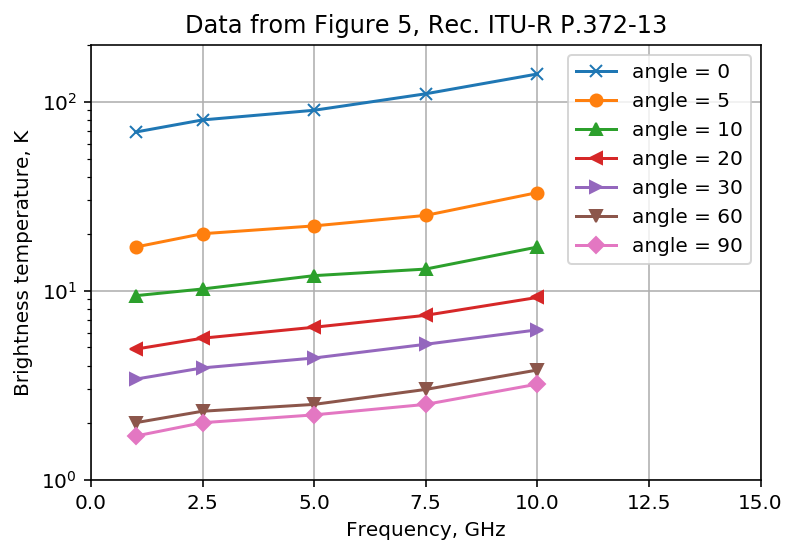

In [8]:
plt.semilogy(freq,T_sky_0,'-x',label='angle = 0')
plt.semilogy(freq,T_sky_5,'-o',label='angle = 5')
plt.semilogy(freq,T_sky_10,'-^',label='angle = 10')
plt.semilogy(freq,T_sky_20,'-<',label='angle = 20')
plt.semilogy(freq,T_sky_30,'->',label='angle = 30')
plt.semilogy(freq,T_sky_60,'-v',label='angle = 60')
plt.semilogy(freq,T_sky_90,'-D',label='angle = 90')

plt.xlabel('Frequency, GHz')
plt.ylabel('Brightness temperature, K')
plt.xlim((0, 10))   # set the xlim to xmin, xmax
plt.ylim((1, 200))   # set the xlim to xmin, xmax
xticks = np.arange(0, 15.1, 2.5)
plt.xticks(xticks)

plt.title('Data from Figure 5, Rec. ITU-R P.372-13')
plt.legend()
plt.grid()
plt.show()

In [9]:
# turn Figure 5 into a function
# do some interpolation to add more data points
fT_sky_0 = interp1d(freq, T_sky_0, kind='linear')
fT_sky_5 = interp1d(freq, T_sky_5, kind='linear')
fT_sky_10 = interp1d(freq, T_sky_10, kind='linear')
fT_sky_20 = interp1d(freq, T_sky_20, kind='linear')
fT_sky_30 = interp1d(freq, T_sky_30, kind='linear')
fT_sky_60 = interp1d(freq, T_sky_60, kind='linear')
fT_sky_90 = interp1d(freq, T_sky_90, kind='linear')

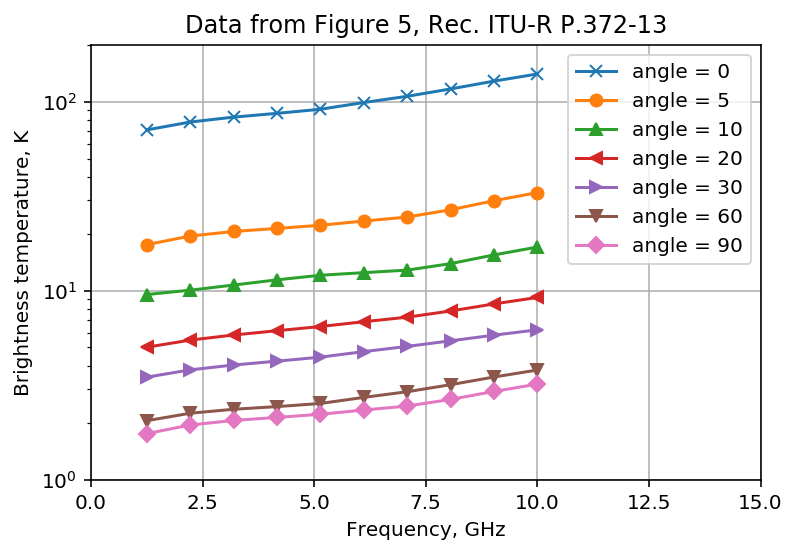

In [10]:
x = np.linspace(1.25,10,10,endpoint=True)  # plot 10 frequencies
plt.semilogy(x,fT_sky_0(x),'-x',label='angle = 0')
plt.semilogy(x,fT_sky_5(x),'-o',label='angle = 5')
plt.semilogy(x,fT_sky_10(x),'-^',label='angle = 10')
plt.semilogy(x,fT_sky_20(x),'-<',label='angle = 20')
plt.semilogy(x,fT_sky_30(x),'->',label='angle = 30')
plt.semilogy(x,fT_sky_60(x),'-v',label='angle = 60')
plt.semilogy(x,fT_sky_90(x),'-D',label='angle = 90')

plt.xlabel('Frequency, GHz')
plt.ylabel('Brightness temperature, K')
plt.xlim((0, 10))   # set the xlim to xmin, xmax
plt.ylim((1, 200))   # set the xlim to xmin, xmax
xticks = np.arange(0, 15.1, 2.5)
plt.xticks(xticks)

plt.title('Data from Figure 5, Rec. ITU-R P.372-13')
plt.legend()
plt.grid()
plt.show()

In [11]:
# find center frequencies, L-Band: 1435 to 1525 MHz, S-Band: 2200 to 2395 MHz &
# C-Band: 4400 to 4940 MHz and 5091 to 5150 MHz
L_band_cntr = (1.435+1.525)/2
S_band_cntr = (2.2+2.395)/2
C_band_cntr = (4.4+5.15)/2

print('L Band center frequency = {:f} GHz'.format(L_band_cntr))
print('S Band center frequency = {:f} GHz'.format(S_band_cntr))
print('C Band center frequency = {:f} GHz'.format(C_band_cntr))

L Band center frequency = 1.480000 GHz
S Band center frequency = 2.297500 GHz
C Band center frequency = 4.775000 GHz


In [12]:
# find sky temperature at each band center and elevation angle
T1_sky_L = np.array([float(fT_sky_0(L_band_cntr)),float(fT_sky_5(L_band_cntr)),float(fT_sky_10(L_band_cntr)),
    float(fT_sky_20(L_band_cntr)),float(fT_sky_30(L_band_cntr)),float(fT_sky_60(L_band_cntr)),float(fT_sky_90(L_band_cntr))])
T1_sky_S = np.array([float(fT_sky_0(S_band_cntr)),float(fT_sky_5(S_band_cntr)),float(fT_sky_10(S_band_cntr)),
    float(fT_sky_20(S_band_cntr)),float(fT_sky_30(S_band_cntr)),float(fT_sky_60(S_band_cntr)),float(fT_sky_90(S_band_cntr))])
T1_sky_C = np.array([float(fT_sky_0(C_band_cntr)),float(fT_sky_5(C_band_cntr)),float(fT_sky_10(C_band_cntr)),
    float(fT_sky_20(C_band_cntr)),float(fT_sky_30(C_band_cntr)),float(fT_sky_60(C_band_cntr)),float(fT_sky_90(C_band_cntr))])

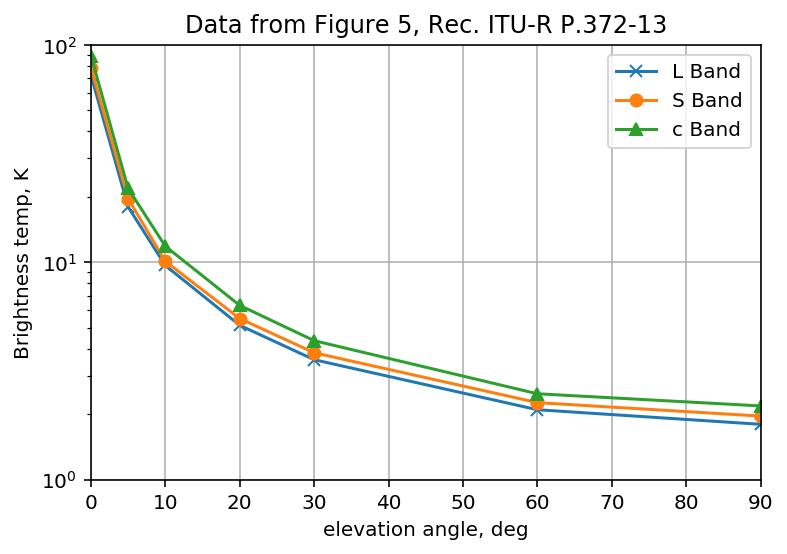

In [13]:
ele_angle = np.array([0,5,10,20,30,60,90],dtype=float)
plt.semilogy(ele_angle,T1_sky_L,'x-',label='L Band')
plt.semilogy(ele_angle,T1_sky_S,'o-',label='S Band')
plt.semilogy(ele_angle,T1_sky_C,'^-',label='c Band')

plt.xlabel('elevation angle, deg')
plt.ylabel('Brightness temp, K')
plt.xlim((0, 90))   # set the xlim to xmin, xmax
plt.ylim((1, 100))   # set the xlim to xmin, xmax

plt.title('Data from Figure 5, Rec. ITU-R P.372-13')
plt.legend()
plt.grid()
plt.show()

Straight line segments on a semi log plot are of the form:   

$y=\lambda a^{\gamma x}$  

which form straight lines when plotted semi-logarithmically, since taking logs of both sides gives  

$\log _{a}y=\gamma x+\log _{a}\lambda$  

This can easily be seen as a line in slope-intercept form with $\gamma$ as the slope and $\log _{a}\lambda$  as the vertical intercept.  

**Probably need to solve for the straight line segments and make a piece wise function.**  

In [14]:
# linear interpolate
fT1_sky_L = interp1d(ele_angle, T1_sky_L, kind='linear')
fT1_sky_S = interp1d(ele_angle, T1_sky_S, kind='linear')
fT1_sky_C = interp1d(ele_angle, T1_sky_C, kind='linear')

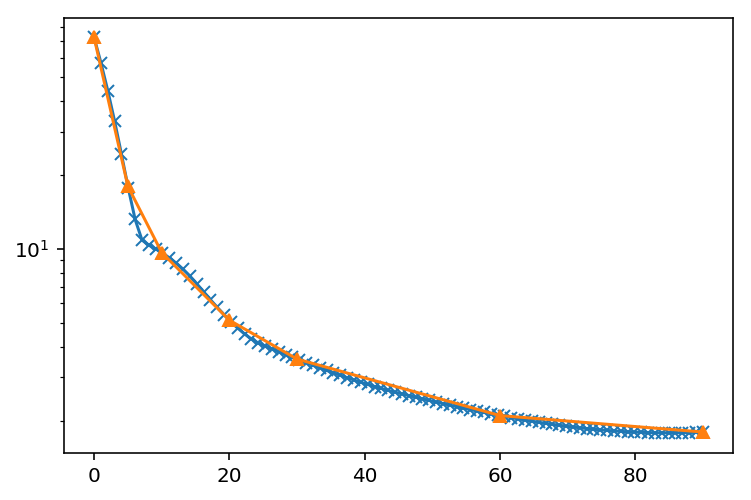

In [15]:
# curve fit to data points
p1 = np.polyfit(ele_angle,T1_sky_L,3)
x = np.linspace(0,90,90,endpoint=True)
#plt.semilogy(x,np.polyval(p1,x),'o-')

spl = splrep(ele_angle, T1_sky_L, k=2)
y2 = splev(x, spl)
plt.semilogy(x,y2,'x-')

y3 = np.interp(x,ele_angle, T1_sky_L)
#plt.semilogy(x,y3,'<-')

plt.semilogy(ele_angle,T1_sky_L,'^-')
plt.show()

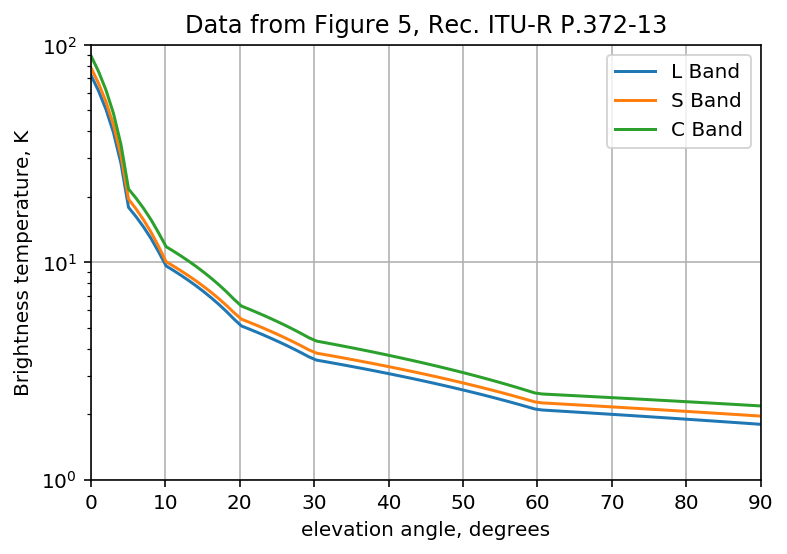

In [16]:
x = np.linspace(0,90,90,endpoint=True)  # plot elevation angles
plt.semilogy(x,fT1_sky_L(x),label='L Band')
plt.semilogy(x,fT1_sky_S(x),label='S Band')
plt.semilogy(x,fT1_sky_C(x),label='C Band')

plt.xlabel('elevation angle, degrees')
plt.ylabel('Brightness temperature, K')
plt.xlim((0, 90))   # set the xlim to xmin, xmax
plt.ylim((1, 100))   # set the xlim to xmin, xmax

plt.title('Data from Figure 5, Rec. ITU-R P.372-13')
plt.legend()
plt.grid()
plt.show()

# Radio noise due to the Earth’s atmosphere for earth stations
See this section for noise temperatures associated with MDA type operations.

# Radio noise due to the Earth’s atmosphere and the Earth’s surface for space stations
The section below applies to look down senarious as seen from a particular nadir angle.

## calculate noise temperature of earth
The brightness temperature of the Earth’s surface is given on page 9 of Rec. ITU-R P.372-7.  
$T = \epsilon T_{surf} + \rho T_{atm}$
where:  
$\epsilon$ = effective emissivity of the surface  
$\rho$ = effective reflection coefficient  
$T_{surf}$ = physical temperature (K) of the Earth’s surface  
$T_{atm}$ = weighted average of the sky brightness temperature.  
Up to about 100 GHz, but particularly below 10 GHz, the reflection coefficient ρ is generally high and the emissivity $\epsilon$ low. 
 
In Fig. 7a) the emissivity and the brightness temperature of a smooth water surface are given for vertical and horizontal polarizations and for two angles of incidence. It should be noted that fresh and salted water are indistinguishable for frequencies greater than 5 GHz.   

Emissivity of a smooth water surface varies by polarization, angle of incedence and frequency.  For frequencies between 1 and 5 GHz, the emissivity varies from 0.2 to 0.47.  

Spectrum of increase in brightness temperature caused by wind at the ocean surface  

In [17]:
# using data from Figure 7, of Rec. ITU-R P.372-7
T_sur = 288 # physical temperature (K) of the sea surface, about 60F
T_atm = 2 + 2.7 #  sky brightness temperature, 90 deg eleveation angle, 1 to 5 GHz approx 2 + 2.7K cosmic 
rho = 0.7 # reflection coefficient, 0.7 is a guess
epsilon = 0.3 #  emissivity of the surface, using 0.3 as an average
T_sea = epsilon*T_sur + rho*T_atm
print('noise temperature of ocean surface = {:.2f} deg K'.format(T_sea))

noise temperature of ocean surface = 89.69 deg K


The emissivities (and hence the brightness temperatures) of land surfaces are higher than those of water surfaces due to the lower dielectric constants of land. In Fig. 8a) the brightness temperature of a smooth field for different moisture contents is shown; in Fig. 8b) the brightness temperature for different degrees of roughness is presented. The curves are given for vertical, horizontal and circular polarization. If the moisture content increases, the brightness temperature decreases; if the roughness is higher, the brightness temperature increases.   

Figure 8 varies from 140 to 280 K

Figure 9 shows calculations of brightness temperature as seen from geostationary orbit by a satellite using an Earth-coverage beam (Earth fills the main beam between 3 dB points). As the satellite moves around its orbit, one can see the effect of the African land mass (hot) at 30° E longitude and of the Pacific Ocean (cold) at 180° W to 150° W longitude. Brightness temperature increases with increasing frequency, largely due to gaseous absorption. Curves are for US Standard Atmosphere with 2.5 g/m3 water vapour and 50% cloud cover. The Earth-coverage antenna pattern is given by G(ϕ) = –3(ϕ/8.715)2 dB for 0 ≤ ϕ ≤ 8.715 where ϕ is the angle off boresight.  

Figure 9 for frequencies of 1 and 6 GHz, noise temperatures varies from 107 to 195 deg K.  

# Man-made noise
For man-made noise this Recommendation gives the external noise figure. That is, the component of the noise which has a Gaussian distribution. Man-made noise often has an impulsive component and this may be important in affecting the performance of radio systems and networks.  
**not included in the analysis**  

# Brightness temperature due to extra-terrestrial sources
As a general rule, for communications below 2 GHz, one needs to be concerned with the Sun and the galaxy (the Milky Way), which appears as a broad belt of strong emission.  

Above 2 GHz, one need consider only the Sun and a few very strong non-thermal sources such as Cassiopeia A, Cygnus A and X and the Crab nebula since the cosmic background contributes 2.7 K only and the Milky Way appears as a narrow zone of somewhat enhanced intensity.  

## Noise temperature of celestial objects
- sun
- moon
- stars

# Atmospheric noise due to lightning
**not included in the analysis**  

# Environmental Noise Temperature
Combine all the noise contributions from above into one matrix.  Data from figure 5 only is defined for elevation values from 0 to 90 degrees.  Need to build Tb to have the same dimensions as the antenna gain data.

## Coordinate system
The angles and axes convention for environmental noise temperature is the same as for antenna radiation patterns. The coordinate system is consistent between the antenna gain and the noise temperature.  Convention for the array, eg. array_name(phi, theta).  

$\phi$ vales define rotation in the plane of the yaw and pitch axes and runs from -180 to 180 ($-\pi$ to $\pi$).  
$\theta$ values define rotation in the plane defined the roll axis and the terminus point of the phi angle and runs from 0 to +180 (0 to $\pi$).  
The antenna elevation angle is $\alpha$ and ranges from 0 to 90 degrees (0 to $\frac{\pi}{2}$).  

Data arrays have the following convetion:  
Data in rows are the values at various $\theta$ angles. The length is +1 because the end points are included.  
Data in columns are the values at various $\phi$ angles.  

The angle phi is taken to be zero degrees at the top center of the vehicle and measured clockwise as viewed from the tail of the missile. The angle theta is zero at the missile nose.  

See IRIG 253-93, Figure 3-4, for a diagram of the aerodynamic vehicle coordinate system

Axis Yaw: A line normal to the center of gravity and perpendicular to the roll axis.  In the case of wing-supported aircraft or missile in straight and level flight with respect to the earth's surface, the yaw axis is in line with the gravitational force vector.  

Axis, Roll: Usually identical to the vehicles longitudal axis, has its orgin at the vehicle's center of gravity with its positive direction towards the leading edge or nose.  

Phi angle: Angle measured in the plane of the yaw and pitch axes.  When viewed from the positive roll axis, phi is measured positive counterclocwise from the positive yaw axis.  

Axis Pitch: A line through the vehicle's normal center of gravity perpendicular to both the roll and yaw axis. For straight and level flight of the vehicle with respect to the earth's surface, the pitch axis is in the horizontal plane.  When viewing the vehicle from its tail or aft position, the positive part of the pitch axis is to the right when the positive part of the yaw axis is down.  

Pitch angle:  Angular displacement about the pitch axis between the roll axis and the reference plane normal defined by the line tangent to the vehicle's trajectory.  

Theta angle:  Angle measured in the plane defined the roll axis and the terminus point of the phi angle.  Theta is measured positive within this plane from the positive roll axis.  



In [63]:
# make variables theta and phi and convert to radians
step = 2  # step size for various ranges
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360

theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)

In [64]:
# create the enviromental noise temperature matrix, for L-Band
elevation_max = 90
x = np.arange(0,elevation_max,step)  # elevation angles, 2 degree increments
Tb1 = fT1_sky_L(x) + 2.725 # sky brightness + cosmic background
Tb1 = np.append(Tb1,fT1_sky_L(90)) # append value at zenith
Tb2 = np.append(Tb1,np.flip(fT1_sky_L(x))) # horizon to horizon

# build enviromental noise temp array
T_env = (np.broadcast_to(Tb2, (len(phi),len(Tb2)))).T  # enviromental noise temperature
print('array, number of rows = {:d}'.format(np.shape(T_env)[0]))
print('array, number of columns = {:d}'.format(np.shape(T_env)[1]))
print('average temperature = {:.1f} deg K'.format(T_env.mean()))

array, number of rows = 91
array, number of columns = 180
average temperature = 8.3 deg K


In [65]:
T_env.shape

(91, 180)

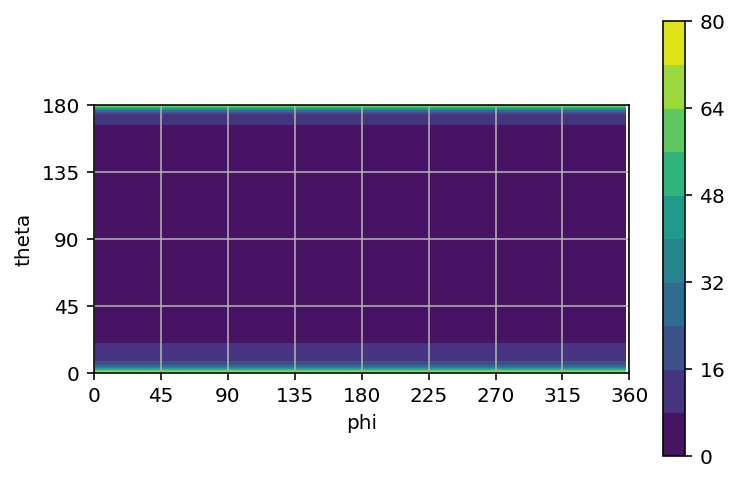

In [66]:
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,T_env,10)
plt.axis('image')
#ax.set_aspect('equal', 'box')
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [67]:
# effective area of isotropic antenna
c = 299792458 # speed of light, m/s
L = c/(L_band_cntr*1e9) # wave length, m
Ae = (L**2)/(4*np.pi) #n effective area, m^2
print('effective area = {:f} m^2'.format(Ae))

# temperature seen by an isotropic antenna, L-Band
print('temperature seen by an isotropic antenna = {:.1f} deg K'.format(T_env.sum()*Ae))

effective area = 0.003265 m^2
temperature seen by an isotropic antenna = 444.1 deg K


In [70]:
# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna radiation pattern by noise temperature distribution and by sine(theta)
f1 = T_env.T*np.sin(theta)
# do a 1-D integral over every row
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(f1[i,:],theta)

# then an integral over the result
T1 = np.trapz(I,phi)

# multiply the antenna radiation pattern by sine(theta)
G = np.ones_like(T_env)
f2 = G.T*np.sin(theta)
# do a 1-D integral over every row
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(f2[i,:],theta)

# then an integral over the result
T2 = np.trapz(I,phi)

T_a = T1/T2
print('numerator = {:.1f}'.format(T1))
print('denominator = {:.1f}'.format(T2))
print('antenna temperature = {:.1f} deg K'.format(T_a))

numerator = 53.0
denominator = 12.5
antenna temperature = 4.2 deg K


# Antenna noise temperature calculation
The antenna temperature performance calculation is conceptually described as multiplying the spatial function of antenna gain by the temperature
distribution of the space surrounding the antenna, integrated over all space. 

The following steps follow the paper in ref[4].  
Link: file:///media/removable/USB%20Drive/Documents/CBITS/papers/antenna%20temperature/Antenna_Noise_Temperature_Calculator.pdf  

Also see: http://www.antenna-theory.com/basics/temperature.php  

**Main steps**  
- read and convert the scale of the radiation pattern and enviromental noise temperature  
- multiply the radiation pattern by the function sine(theta)  
- calculate the radiated power for the antenna pattern normalization  
- rotate the enviromental noise temperature by angle alpha around the x-axis using precalculated rotation matrix  
- multiply the rotated enviromentral noise temperature by the radiation pattern  
- integrate the rsults from previou steps over angle phi and theta  
- divide the results of the integration by the radiated power. This result if the antenna noise temperature for the angle alpha  

## read and convert the scale of the radiation pattern and enviromental noise temperature  
- See phased array pattern.py on desktop computer  
- fix orientation of hex pattern array  
- need to use other radiation pattern to create and save off a data file.  

# Antenna radiation pattern
For now, the antenna radiation pattern is omni isotropic, 0 dBi.  
Later read antenna pattern from file.  

In [60]:
# read array factor
AF = pickle.load(open("AF.pkl", "rb")) # data file created by 'Array factor.ipynb'

# read element pattern
R = pickle.load(open("EP.pkl", "rb")) # data file created by 'element pattern.ipynb'

G = R*abs(AF)  # calculate array gain

# Antenna Temperature
Antenna Temperature is a parameter that describes how much noise an antenna produces in a given environment. This temperature is not the physical temperature of the antenna. Moreover, an antenna does not have an intrinsic "antenna temperature" associated with it; rather the temperature depends on its gain pattern and the thermal environment that it is placed in. Antenna temperature is also sometimes referred to as Antenna Noise Temperature.  

To define the environment (and hence give the full definition of antenna temperature), we will introduce a temperature distribution - this is the temperature in every direction away from the antenna in spherical coordinates. For instance, the night sky is roughly 4 Kelvin; the value of the temperature pattern in the direction of the Earth's ground is the physical temperature of the Earth's ground. This temperature distribution will be written as  temperature distribution. Hence, an antenna's temperature will vary depending on whether it is directional and pointed into space or staring into the sun.  

For an antenna with a radiation pattern given by $G(\theta,\phi)$, the antenna temperature is defined as:  

$T_A = \frac{1}{4\pi}\int_{0}^{2\pi} \int_{0}^{\pi} G(\theta,\phi)T_{env}(\theta,\phi)sin(\theta)d\theta d\phi$  
the equation above gave a large value


$T_A = \frac {\int_{0}^{2\pi} \int_{0}^{\pi} G(\theta,\phi)T_{env}(\theta,\phi)sin(\theta)d\theta d\phi} {\int_{0}^{2\pi} \int_{0}^{\pi} G(\theta,\phi)sin(\theta)d\theta d\phi}$  


re-write and add references  

In [59]:
# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

# multiply the antenna radiation pattern by noise temperature distribution and by sine(theta)
f1 = (G*T_env).T*np.sin(theta)
# do a 1-D integral over every row
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(f1[i,:],theta)

# then an integral over the result
T1 = np.trapz(I,phi)

# multiply the antenna radiation pattern by sine(theta)
f2 = G.T*np.sin(theta)
# do a 1-D integral over every row
I = np.zeros(len(phi))
for i in range(len(phi)):
    I[i] = np.trapz(f2[i,:],theta)

# then an integral over the result
T2 = np.trapz(I,phi)

T_a = T1/T2
print('numerator = {:.1f}'.format(T1))
print('denominator = {:.1f}'.format(T2))
print('antenna temperature = {:.1f} deg K'.format(T_a))

numerator = 83807.5
denominator = 5774.7
antenna temperature = 14.5 deg K


## calculate the radiated power for the antenna pattern normalization

## Enviromental Noise Temperature Matrix Rotation
See pages: 5-7  
rotate the enviromental noise temperature by angle alpha around the x-axis using precalculated rotation matrix  

To calculate antenna noise temperature for a desired angle alpha we must rotate the enviromental noise temperature matrix or antenna radiation pattern through the angle Alpha. 

In ANTC, we choose to rotate noise temperature due to its lower range of values, in what is from a mathematical point of view an equivalent operation. 

The first versions of the C++ program (to version 3.0) employed a direct rotation of the noise temperature matrix. 

Since rotation in spherical coordinates is very complicated, the data format was converted to Cartesian coordinates prior to performing a Cartesian rotation using the following formula: 


# Spherical earth
calculations for range to horizon vs altitude and beamwidth.  

The spherical earth propagation model approximates the effects of earth's curvature and refraction by assuming the propagation is along straight lines and with the earth's "effective" radius being a_eff.

The effective earth radius ae depends on atmospheric conditions, but often it is assumed to be 8,493 km which is 4/3 times the 6,370 km value conventionally assumed for the actual earth radius. Sometimes it is said that the 4/3 radius is the effective earth radius for a "standard" atmosphere.  

Reference:  
Antennas: fundementals, design, measurement, 3rd edition, Lamont Blake, Maurice Long, 2009  

Blake, Lamont V.; Long, Maurice W.: 'Antennas: Fundamentals, design, measurement' (Electromagnetic Waves, 2009) DOI: 
IET Digital Library, http://digital-library.theiet.org/content/books/ew/sbew040e  



In [16]:
#effective radius of 4/3 earth in meters, based on earth radius of 6370 km
earth_radius = 6370*1e3
a_eff = earth_radius*4/3
print('effective radius of earth = {:,.1f} km'.format(a_eff/1000))

# antenna height
h_ft = 30000  # feet
h = 0.3048*h_ft # meters
print('antenna height = {:,.1f} m'.format(h))

# slant range from antenna to horizon
Rmax = np.sqrt(2*a_eff*h + h**2)
print('slant range from antenna to horizon = {:,.1f} km'.format(Rmax/1000))

# depression angle
Theta_r = np.arcsin((2*a_eff*h+h**2+Rmax**2)/(2*(a_eff+h)*Rmax))
print('depression angle = {:.2f} deg'.format(Theta_r*180/np.pi))

effective radius of earth = 8,493.3 km
antenna height = 9,144.0 m
slant range from antenna to horizon = 394.2 km
depression angle = 2.66 deg


# Sky temperature from WG#2
Sky temperature data presented at WG#2.  Compare this data to Figure 5 data.  

In [0]:
# sky temperature data from WG#2
theta = np.array([90,30,10,5,0],dtype=float)
T_sky_L = np.array([14,16,21,30,290],dtype=float)
T_sky_S = np.array([8,10,18,28,290],dtype=float)
T_sky_C = np.array([5,8,15,27,290],dtype=float)

In [0]:
plt.plot(theta,T_sky_L,'x-',label='L Band')
plt.plot(theta,T_sky_S,'o-',label='S Band')
plt.plot(theta,T_sky_C,'^-',label='c Band')

plt.xlabel('elevation angle, deg')
plt.ylabel('T sky, K')
plt.xlim((1, 90))   # set the xlim to xmin, xmax
plt.ylim((0, 50))   # set the xlim to xmin, xmax

plt.title('Sky temperature data from WG#2')
plt.legend()
plt.grid()
plt.show()